<a href="https://colab.research.google.com/github/Dev-debasish-09/Food_Delivery_Time_prediction/blob/main/Baseline_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
import data_clean_utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [19]:
from sklearn import set_config

set_config(transform_output="pandas")

In [20]:
# load the data

df = pd.read_csv('/content/My_Data.csv')

In [21]:
import inspect

# Get all members of the module
all_members = inspect.getmembers(data_clean_utils)

# Filter for functions and print their names
functions = [name for name, member in all_members if inspect.isfunction(member)]
print("Available functions in data_clean_utils:")
for func in functions:
    print(func)

Available functions in data_clean_utils:
calculating_haversine_distance
change_col_names
clean_lat_long
create_distance_type
data_cleaning
extract_datetime_features
perform_cleaning
time_of_day


In [23]:
df = pd.read_csv('/content/My_new_Data.csv')

In [24]:
df

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minute,order_time_hr,order_time_of_day,distance,distance_type
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,Sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,Morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,Stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,Evening,20.183530,very_long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,Sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,Morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,Sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,Evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,Cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,Afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,Windy,high,...,JAP,24,3,thursday,0,10.0,11.0,Morning,1.489846,short
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,Windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,Evening,NaN,NaN
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,Cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,Night,4.657195,short
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,Cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,Afternoon,6.232393,medium


In [26]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minute',
       'order_time_hr', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [28]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hr",
                    "order_day"]

df.drop(columns=columns_to_drop, inplace=True)

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,city_name,order_month,order_day_of_week,is_weekend,pickup_time_minute,order_time_of_day,distance,distance_type
0,37.0,4.9,Sunny,high,2,snack,motorcycle,0.0,no,urban,24,INDO,3,saturday,1,15.0,Morning,3.025149,short
1,34.0,4.5,Stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,BANG,3,friday,0,5.0,Evening,20.183530,very_long
2,23.0,4.4,Sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,BANG,3,saturday,1,15.0,Morning,1.552758,short
3,38.0,4.7,Sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,COIMB,4,tuesday,0,10.0,Evening,7.790401,medium
4,32.0,4.6,Cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,CHEN,3,saturday,1,15.0,Afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,Windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,JAP,3,thursday,0,10.0,Morning,1.489846,short
45498,21.0,4.6,Windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,AGR,2,wednesday,0,15.0,Evening,NaN,NaN
45499,30.0,4.9,Cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,CHEN,3,friday,0,15.0,Night,4.657195,short
45500,20.0,4.7,Cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,COIMB,3,monday,0,5.0,Afternoon,6.232393,medium


In [29]:
# check for missing values

df.isna().sum()

,0
age,1854
ratings,1908
weather,525
traffic,510
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,993
festival,228
city_type,1198


In [30]:
# check for duplicates

df.duplicated().sum()

np.int64(0)

<Axes: >

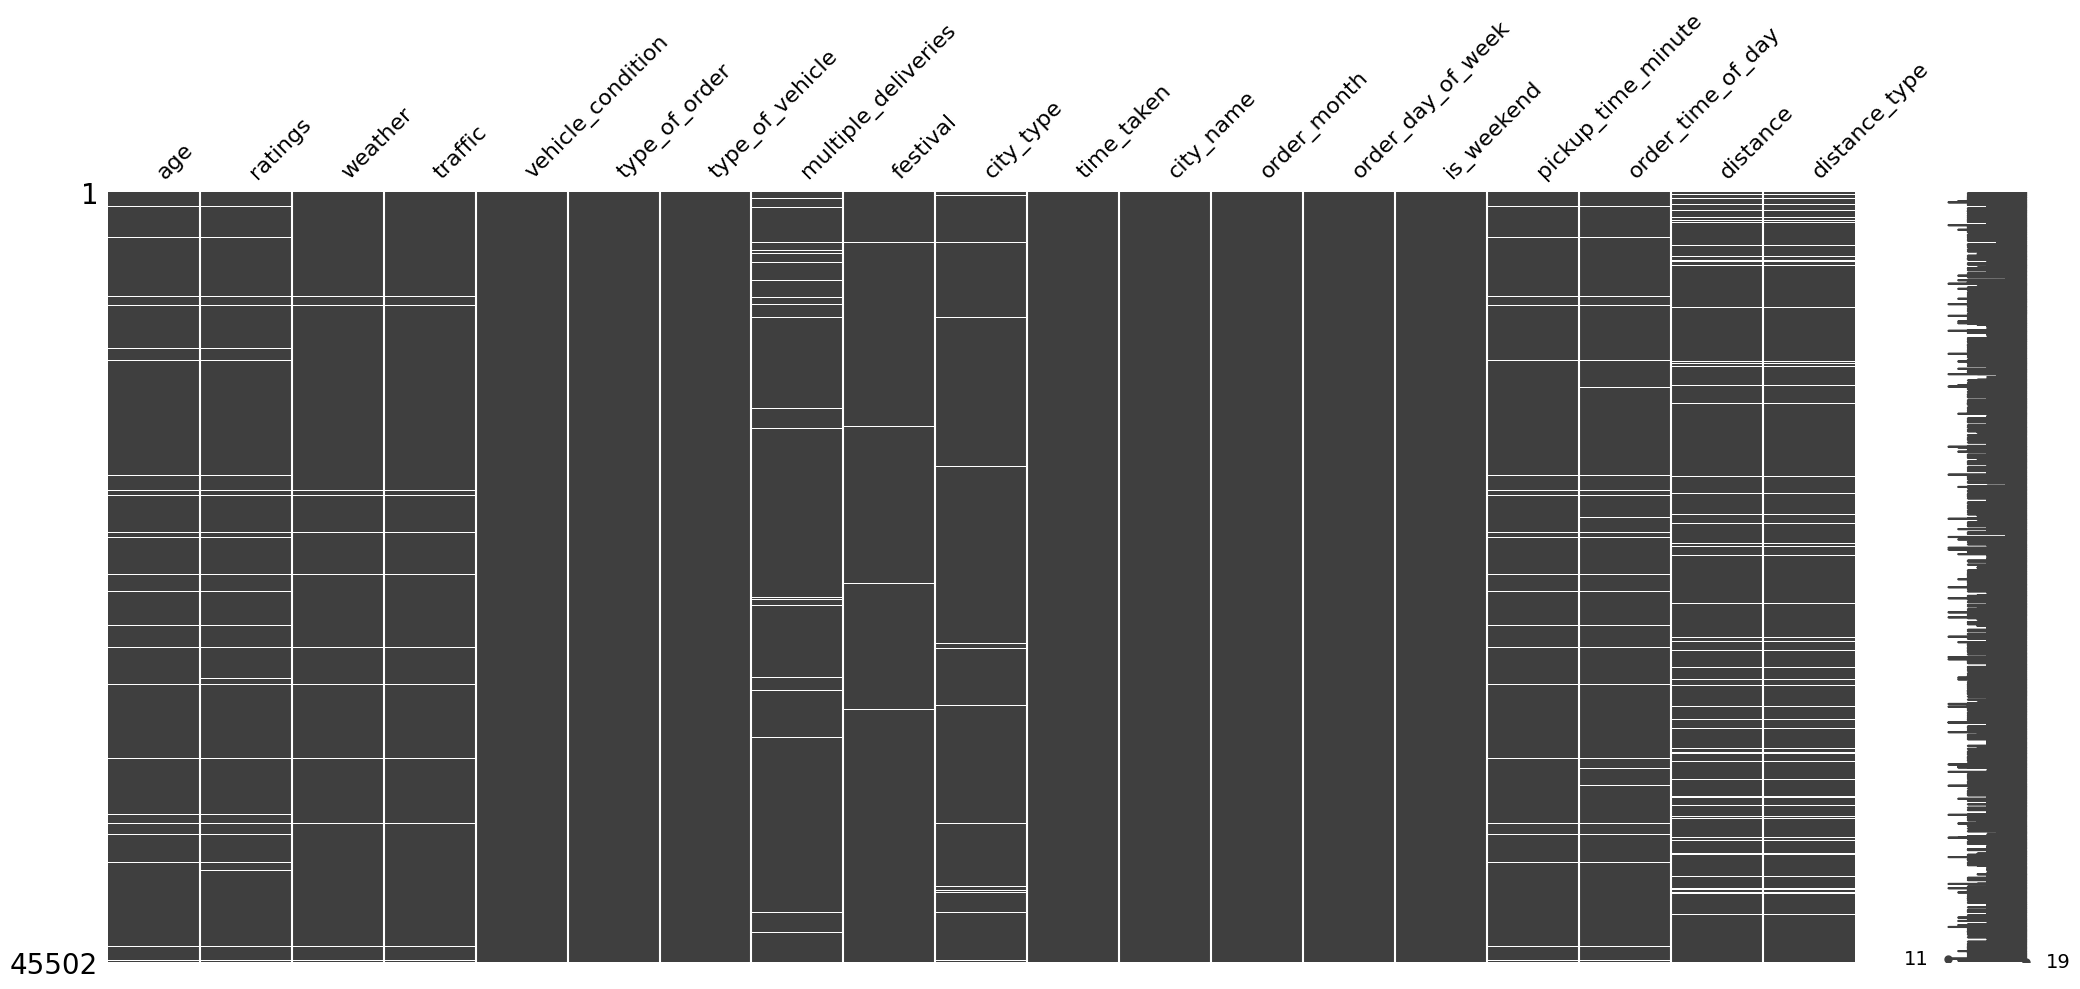

In [31]:
import missingno as msno

msno.matrix(df)

In [32]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minute', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

Data Preparation

In [33]:
temp_df = df.copy().dropna()

In [35]:
temp_df.shape

(37695, 19)

In [36]:
# split x and y

x = temp_df.drop(columns=['time_taken'])
y = temp_df['time_taken']

In [37]:
x

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,city_name,order_month,order_day_of_week,is_weekend,pickup_time_minute,order_time_of_day,distance,distance_type
0,37.0,4.9,Sunny,high,2,snack,motorcycle,0.0,no,urban,INDO,3,saturday,1,15.0,Morning,3.025149,short
1,34.0,4.5,Stormy,jam,2,snack,scooter,1.0,no,metropolitian,BANG,3,friday,0,5.0,Evening,20.183530,very_long
2,23.0,4.4,Sandstorms,low,0,drinks,motorcycle,1.0,no,urban,BANG,3,saturday,1,15.0,Morning,1.552758,short
3,38.0,4.7,Sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,COIMB,4,tuesday,0,10.0,Evening,7.790401,medium
4,32.0,4.6,Cloudy,high,1,snack,scooter,1.0,no,metropolitian,CHEN,3,saturday,1,15.0,Afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45496,35.0,4.2,Windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,RANCHI,3,tuesday,0,10.0,Night,16.600272,very_long
45497,30.0,4.8,Windy,high,1,meal,motorcycle,0.0,no,metropolitian,JAP,3,thursday,0,10.0,Morning,1.489846,short
45499,30.0,4.9,Cloudy,low,1,drinks,scooter,0.0,no,metropolitian,CHEN,3,friday,0,15.0,Night,4.657195,short
45500,20.0,4.7,Cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,COIMB,3,monday,0,5.0,Afternoon,6.232393,medium


In [38]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [39]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(30156, 18)
(7539, 18)
(30156,)
(7539,)


In [40]:
x_train.isna().sum()

,0
age,0
ratings,0
weather,0
traffic,0
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,0
festival,0
city_type,0


In [48]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minute","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type","city_name","order_month",
                    "order_day_of_week",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [49]:
len(num_cols + nominal_cat_cols + ordinal_cat_cols)

16

In [50]:
for col in ordinal_cat_cols:
    print(col,x_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium' 'short' 'long' 'very_long']


In [51]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [52]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order]), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

preprocessor.set_output(transform="pandas")

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minute',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'city_name',
                                  'order_month', 'order_day_of_week',
                                  'is_weekend', 'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']]),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [53]:
# transform the data

X_train_trans = preprocessor.fit_transform(x_train)
X_test_trans = preprocessor.transform(x_test)

X_train_trans

,age,ratings,pickup_time_minute,distance,weather_Fog,weather_Sandstorms,weather_Stormy,weather_Sunny,weather_Windy,type_of_order_drinks,...,order_day_of_week_tuesday,order_day_of_week_wednesday,is_weekend_1,order_time_of_day_Evening,order_time_of_day_Morning,order_time_of_day_Night,traffic,distance_type,vehicle_condition,multiple_deliveries
8708,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
25198,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
34049,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
25987,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
37121,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20239,0.578947,0.92,0.5,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7590,0.052632,1.00,1.0,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13610,0.526316,0.92,0.0,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1045,0.947368,0.96,0.5,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [54]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [55]:
pt.lambdas_

array([0.32446096])

In [56]:
y_train_pt

,x0
0,2.028672
1,0.554539
2,-2.024267
3,-0.173699
4,0.554539
...,...
30151,0.457580
30152,-0.173699
30153,-1.350937
30154,0.047111


Training of base line model

In [57]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_trans,y_train_pt)

LinearRegression()

In [58]:
# get the predictions
y_pred_train = lr.predict(X_train_trans)
y_pred_test = lr.predict(X_test_trans)

In [59]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [60]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 4.70 minutes
The test error is 4.69 minutes


In [61]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.60
The test r2 score is 0.60


## impute missing values

In [62]:
temp_df = df.copy()

In [63]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,city_name,order_month,order_day_of_week,is_weekend,pickup_time_minute,order_time_of_day,distance,distance_type
0,37.0,4.9,Sunny,high,2,snack,motorcycle,0.0,no,urban,INDO,3,saturday,1,15.0,Morning,3.025149,short
1,34.0,4.5,Stormy,jam,2,snack,scooter,1.0,no,metropolitian,BANG,3,friday,0,5.0,Evening,20.183530,very_long
2,23.0,4.4,Sandstorms,low,0,drinks,motorcycle,1.0,no,urban,BANG,3,saturday,1,15.0,Morning,1.552758,short
3,38.0,4.7,Sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,COIMB,4,tuesday,0,10.0,Evening,7.790401,medium
4,32.0,4.6,Cloudy,high,1,snack,scooter,1.0,no,metropolitian,CHEN,3,saturday,1,15.0,Afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,Windy,high,1,meal,motorcycle,0.0,no,metropolitian,JAP,3,thursday,0,10.0,Morning,1.489846,short
45498,21.0,4.6,Windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,AGR,2,wednesday,0,15.0,Evening,NaN,NaN
45499,30.0,4.9,Cloudy,low,1,drinks,scooter,0.0,no,metropolitian,CHEN,3,friday,0,15.0,Night,4.657195,short
45500,20.0,4.7,Cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,COIMB,3,monday,0,5.0,Afternoon,6.232393,medium


In [64]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [65]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (36401, 18)
The shape of test data is (9101, 18)


In [66]:
# missing values in train data

X_train.isna().sum()

,0
age,1470
ratings,1510
weather,421
traffic,407
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,795
festival,188
city_type,968


In [67]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [68]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minute', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [69]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


np.float64(17.0)

Age

In [73]:
X_train['age'].describe()

,age
count,34931.000000
mean,29.569551
std,5.752869
min,20.000000
25%,25.000000
50%,30.000000
75%,35.000000
max,39.000000


In [72]:
# missing values in the column

X_train['age'].isna().sum()

np.int64(1470)

In [74]:
# median value

age_median = X_train['age'].median()

Avg and Median values are similar, impute the age column with median value

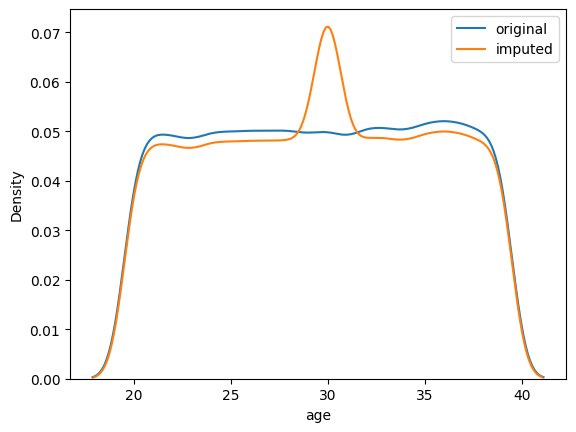

In [75]:
# plot the kde plot

sns.kdeplot(X_train['age'],label="original")
sns.kdeplot(X_train['age'].fillna(age_median),label="imputed")
plt.legend()

Observation:

Changed the distribution of the age column.
Use Advanced imputation techniques like KNN imputer.

Ratings

In [76]:
# statistical summary

X_train['ratings'].describe()

,ratings
count,34891.000000
mean,4.635058
std,0.314049
min,2.500000
25%,4.500000
50%,4.700000
75%,4.900000
max,5.000000


In [77]:
# missing values

X_train['ratings'].isna().sum()

np.int64(1510)

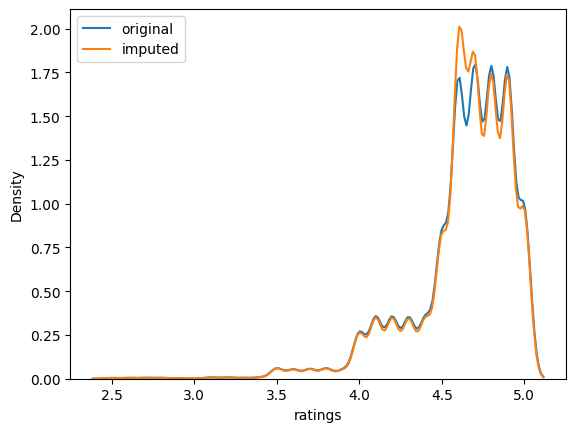

In [78]:
# avg rating

ratings_mean = X_train['ratings'].mean()

# fill and plot kdeplot

sns.kdeplot(X_train['ratings'],label="original")
sns.kdeplot(X_train['ratings'].fillna(ratings_mean),label="imputed")
plt.legend()

Weather

In [79]:
# value counts

X_train['weather'].value_counts()

,count
weather,
Fog,6160
Stormy,6051
Cloudy,6033
Sandstorms,5958
Windy,5928
Sunny,5850


In [80]:
# missing values in the column

X_train['weather'].isna().sum()

np.int64(421)

<Axes: xlabel='count', ylabel='weather'>

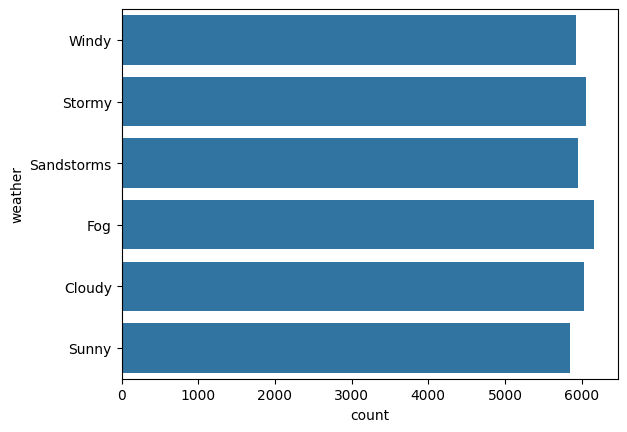

In [81]:
# countplot

sns.countplot(X_train['weather'])

No dominant category to impute from

In [82]:
# capture the missingness

missing_weather = MissingIndicator()
missing_weather.set_output(transform="pandas")

pd.concat([X_train['weather'],missing_weather.fit_transform(X_train[['weather']])],axis=1).sample(50)

,weather,missingindicator_weather
2176,Fog,False
276,Stormy,False
36748,Windy,False
40966,Fog,False
10967,Fog,False
35982,Sandstorms,False
16040,Fog,False
30013,Stormy,False
32525,Cloudy,False
462,Fog,False


Traffic

In [83]:
# value counts

X_train['traffic'].value_counts()

,count
traffic,
low,12323
jam,11320
medium,8773
high,3578


In [84]:
# Missing values in column

X_train['traffic'].isna().sum()

np.int64(407)

<Axes: xlabel='count', ylabel='traffic'>

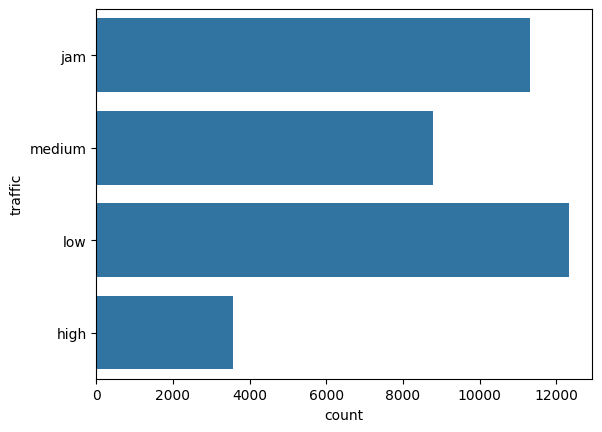

In [85]:
# countplot

sns.countplot(X_train['traffic'])

In [86]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minute', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

Multiple deliveries

In [87]:
# value counts

X_train['multiple_deliveries'].value_counts()

,count
multiple_deliveries,
1.0,22487
0.0,11252
2.0,1599
3.0,268


<Axes: xlabel='count', ylabel='multiple_deliveries'>

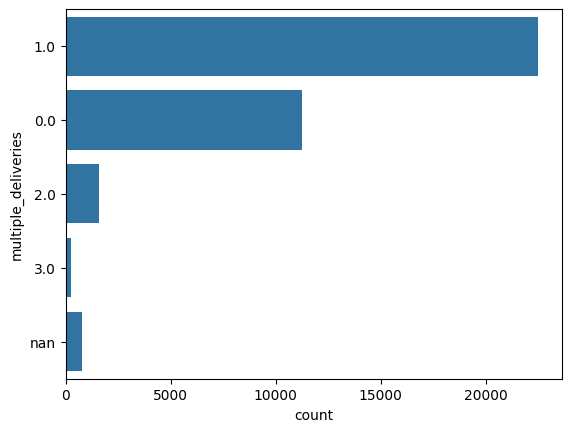

In [88]:
# countplot

sns.countplot(X_train['multiple_deliveries'].apply(str))

In [89]:
# number of missing values

X_train['multiple_deliveries'].isna().sum()

np.int64(795)

In [90]:
# mode value

multiple_deliveries_mode = X_train['multiple_deliveries'].mode()[0]

<Axes: xlabel='count', ylabel='multiple_deliveries'>

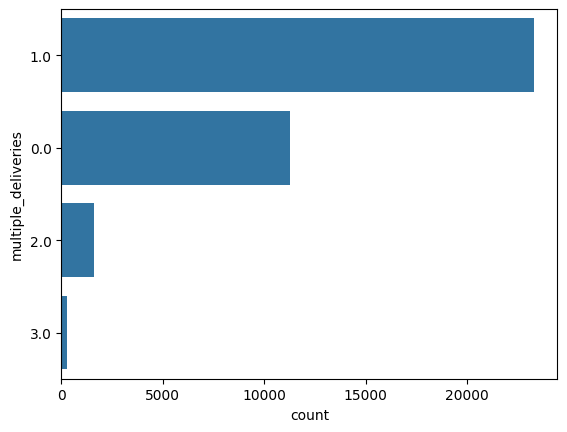

In [91]:
# fill na values with mode

sns.countplot(X_train['multiple_deliveries'].fillna(multiple_deliveries_mode).apply(str))

Mode can be used for this column as an imputation technique

Festival

In [92]:
# value counts

X_train['festival'].value_counts()

,count
festival,
no,35474
yes,739


<Axes: xlabel='count', ylabel='festival'>

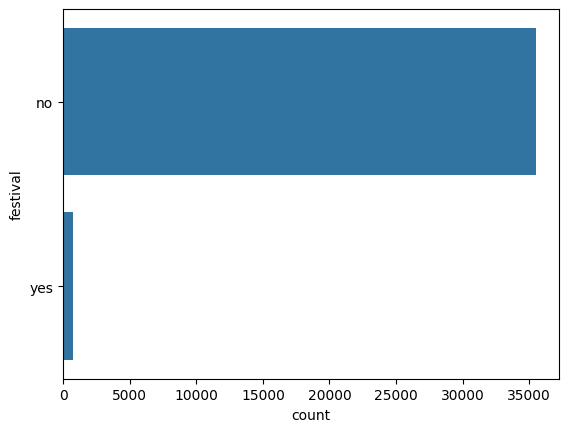

In [93]:
# countplot

sns.countplot(X_train['festival'])

In [94]:
# missing values in column

X_train['festival'].isna().sum()

np.int64(188)

In [95]:
# mode value

festival_mode = X_train['festival'].mode()[0]

<Axes: xlabel='count', ylabel='festival'>

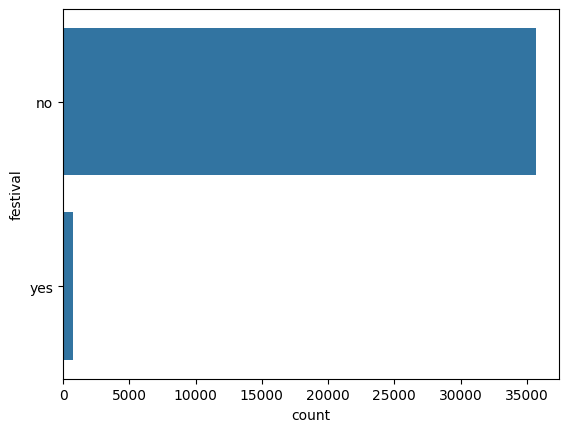

In [96]:
# fill with mode

sns.countplot(X_train['festival'].fillna(festival_mode))

City Type

In [97]:
# value counts

X_train['city_type'].value_counts()

,count
city_type,
metropolitian,27245
urban,8058
semi-urban,130


In [98]:
# number of missing values

X_train['city_type'].isna().sum()

np.int64(968)

<Axes: xlabel='count', ylabel='city_type'>

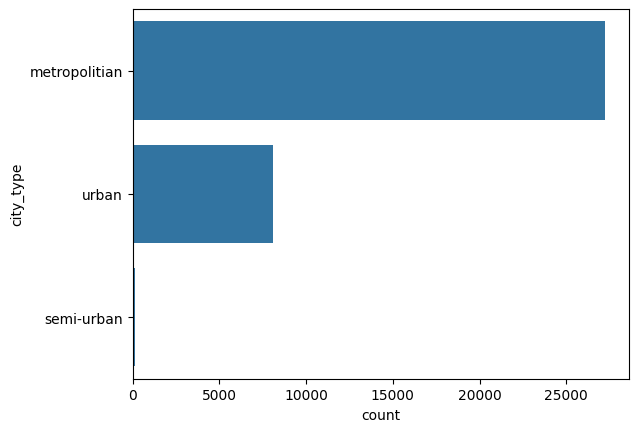

In [99]:
# countplot

sns.countplot(X_train['city_type'])

In [100]:
# mode value

city_type_mode = X_train['city_type'].mode()[0]

<Axes: xlabel='count', ylabel='city_type'>

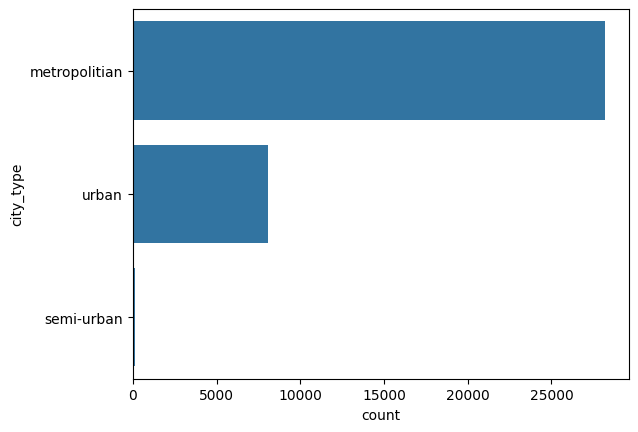

In [101]:
# fill with mode

sns.countplot(X_train['city_type'].fillna(city_type_mode))

In [102]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minute', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

pickup time minutes

In [104]:
# statistical summary

X_train['pickup_time_minute'].describe()

,pickup_time_minute
count,35103.000000
mean,9.998718
std,4.082279
min,5.000000
25%,5.000000
50%,10.000000
75%,15.000000
max,15.000000


In [105]:
# missing values in the column

X_train['pickup_time_minute'].isna().sum()

np.int64(1298)

In [107]:
# median value

pickup_time_minutes_median = X_train['pickup_time_minute'].median()

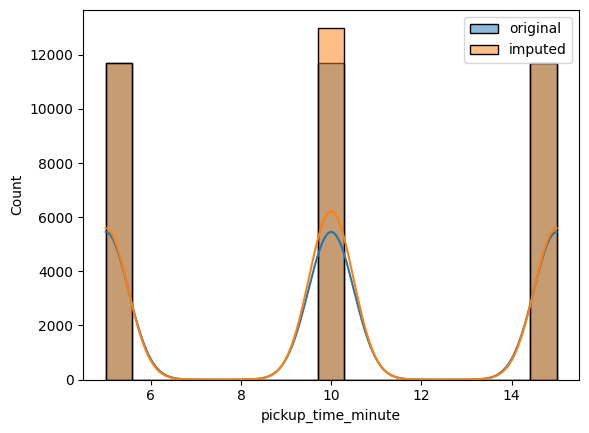

In [109]:
# histplot

sns.histplot(X_train['pickup_time_minute'],kde=True,label='original')
sns.histplot(X_train['pickup_time_minute'].fillna(pickup_time_minutes_median),kde=True,label='imputed')
plt.legend()

Order time of day

In [110]:
# value counts

X_train['order_time_of_day'].value_counts()

,count
order_time_of_day,
Night,10994
Evening,10906
Morning,6883
Afternoon,5972


In [111]:
# missing values

X_train['order_time_of_day'].isna().sum()

np.int64(1646)

<Axes: xlabel='count', ylabel='order_time_of_day'>

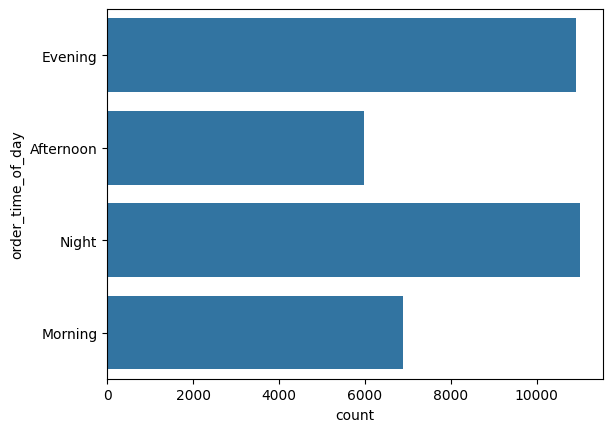

In [112]:
# countplot

sns.countplot(X_train['order_time_of_day'])

In [113]:
# rows where the data is missing

X_train[X_train['order_time_of_day'].isna()]

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,city_name,order_month,order_day_of_week,is_weekend,pickup_time_minute,order_time_of_day,distance,distance_type
14475,NaN,NaN,Stormy,low,2,meal,scooter,1.0,no,metropolitian,MYS,3,saturday,1,NaN,NaN,1.554563,short
21916,20.0,2.8,Sunny,low,2,drinks,scooter,1.0,no,metropolitian,JAP,3,wednesday,0,10.0,NaN,10.427236,long
34951,28.0,5.0,Fog,low,2,snack,motorcycle,1.0,no,metropolitian,HYD,3,sunday,1,15.0,NaN,16.903757,very_long
8165,NaN,NaN,NaN,NaN,3,meal,scooter,1.0,no,metropolitian,KOL,2,wednesday,0,NaN,NaN,19.673431,very_long
23469,NaN,NaN,Sunny,jam,0,buffet,motorcycle,1.0,no,metropolitian,COIMB,4,tuesday,0,NaN,NaN,4.674220,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33827,NaN,NaN,NaN,NaN,3,drinks,electric_scooter,1.0,no,urban,GOA,2,monday,0,NaN,NaN,NaN,NaN
22403,NaN,NaN,Sunny,low,0,snack,motorcycle,1.0,no,urban,INDO,3,monday,0,NaN,NaN,3.024981,short
21518,NaN,NaN,Stormy,jam,1,meal,scooter,0.0,no,urban,MYS,4,saturday,1,NaN,NaN,17.097973,very_long
22002,25.0,5.0,Sunny,low,1,meal,scooter,1.0,no,metropolitian,LUDH,2,tuesday,0,5.0,NaN,8.789430,medium


Distance

In [114]:
# statistical summary

X_train['distance'].describe()

,distance
count,33470.000000
mean,9.738154
std,5.608401
min,1.465067
25%,4.657672
50%,9.193421
75%,13.681057
max,20.969489


In [115]:
# number of missing values

X_train['distance'].isna().sum()

np.int64(2931)

In [116]:
# avg distance

distance_mean = X_train['distance'].mean()

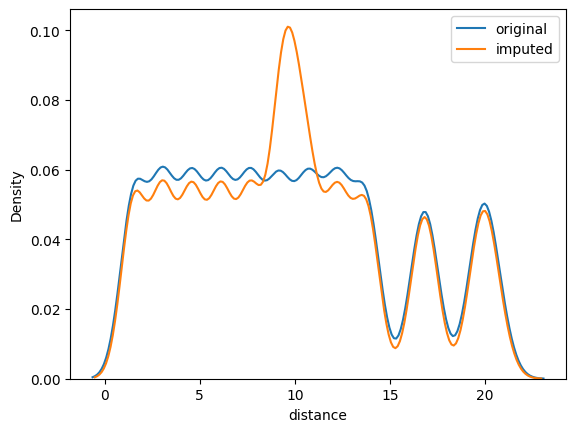

In [117]:
# kdeplot

sns.kdeplot(X_train['distance'],label='original')
sns.kdeplot(X_train['distance'].fillna(distance_mean),label='imputed')
plt.legend()

In [118]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minute', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

Distance Type

In [119]:
# value counts

X_train['distance_type'].value_counts()

,count
distance_type,
long,9025
short,8998
medium,8993
very_long,6454


In [120]:
# missing values

X_train['distance_type'].isna().sum()

np.int64(2931)

<Axes: xlabel='count', ylabel='distance_type'>

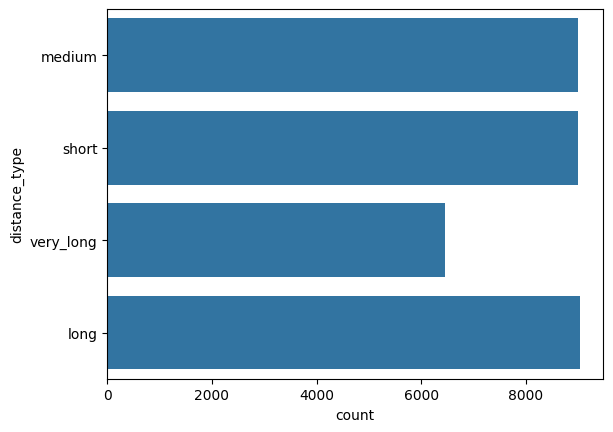

In [121]:
# countplot

sns.countplot(X_train['distance_type'])

Imputation Pipeline

In [122]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'city_name',
 'order_month',
 'order_day_of_week',
 'is_weekend',
 'order_time_of_day']

In [123]:
X_train.isna().sum()

,0
age,1470
ratings,1510
weather,421
traffic,407
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,795
festival,188
city_type,968


In [124]:
# features to fill values with mode

features_to_fill_mode = ['multiple_deliveries','festival','city_type']
features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

features_to_fill_missing

['weather',
 'type_of_order',
 'type_of_vehicle',
 'city_name',
 'order_month',
 'order_day_of_week',
 'is_weekend',
 'order_time_of_day']

In [125]:
# simple imputer to fill categorical vars with mode

simple_imputer = ColumnTransformer(transformers=[
    ("mode_imputer",SimpleImputer(strategy="most_frequent"),features_to_fill_mode),
    ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing"),features_to_fill_missing)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

simple_imputer

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('mode_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['multiple_deliveries', 'festival',
                                  'city_type']),
                                ('missing_imputer',
                                 SimpleImputer(fill_value='missing',
                                               strategy='constant'),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'city_name', 'order_month',
                                  'order_day_of_week', 'is_weekend',
                                  'order_time_of_day'])],
                  verbose_feature_names_out=False)

In [126]:
simple_imputer.fit_transform(X_train)

,multiple_deliveries,festival,city_type,weather,type_of_order,type_of_vehicle,city_name,order_month,order_day_of_week,is_weekend,order_time_of_day,age,ratings,traffic,vehicle_condition,pickup_time_minute,distance,distance_type
11029,1.0,no,metropolitian,Windy,snack,electric_scooter,MUM,3,wednesday,0,Evening,26.0,4.7,jam,2,10.0,9.177684,medium
15665,1.0,no,metropolitian,Windy,drinks,motorcycle,SUR,3,thursday,0,Afternoon,21.0,4.9,medium,2,5.0,6.081536,medium
14475,1.0,no,metropolitian,Stormy,meal,scooter,MYS,3,saturday,1,missing,NaN,NaN,low,2,NaN,1.554563,short
29199,1.0,no,metropolitian,Windy,buffet,motorcycle,JAP,4,monday,0,Evening,32.0,4.7,medium,0,15.0,20.852271,very_long
22514,0.0,no,urban,Sandstorms,meal,scooter,RANCHI,3,wednesday,0,Night,34.0,4.9,jam,1,5.0,9.056096,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,no,metropolitian,Sandstorms,meal,scooter,COIMB,4,monday,0,Evening,29.0,4.7,jam,2,5.0,12.464367,long
44732,0.0,no,urban,Cloudy,buffet,motorcycle,SUR,3,wednesday,0,Morning,36.0,4.8,low,0,10.0,1.520432,short
38158,0.0,no,metropolitian,Fog,buffet,scooter,BHP,2,thursday,0,Evening,36.0,4.4,jam,1,10.0,NaN,NaN
860,1.0,no,metropolitian,Windy,meal,scooter,CHEN,3,saturday,1,Afternoon,25.0,4.9,medium,2,5.0,7.760938,medium


In [127]:
simple_imputer.fit_transform(X_train).isna().sum()

,0
multiple_deliveries,0
festival,0
city_type,0
weather,0
type_of_order,0
type_of_vehicle,0
city_name,0
order_month,0
order_day_of_week,0
is_weekend,0


In [128]:
# knn imputer

knn_imputer = KNNImputer(n_neighbors=5)

In [129]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minute","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type","city_name","order_month",
                    "order_day_of_week",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [130]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [131]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'low' 'high' nan]
distance_type ['medium' 'short' 'very_long' 'long' nan]


In [132]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minute',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'city_name',
                                  'order_month', 'order_day_of_week',
                                  'is_weekend', 'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [133]:
preprocessor.fit_transform(X_train)

,age,ratings,pickup_time_minute,distance,weather_Fog,weather_Sandstorms,weather_Stormy,weather_Sunny,weather_Windy,weather_nan,...,order_day_of_week_wednesday,is_weekend_1,order_time_of_day_Evening,order_time_of_day_Morning,order_time_of_day_Night,order_time_of_day_nan,traffic,distance_type,vehicle_condition,multiple_deliveries
11029,0.315789,0.88,0.5,0.395429,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2,1.0
15665,0.052632,0.96,0.0,0.236688,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0
14475,NaN,NaN,NaN,0.004588,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1.0
29199,0.631579,0.88,1.0,0.993990,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0,1.0
22514,0.736842,0.96,0.0,0.389195,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.473684,0.88,0.0,0.563939,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,0.0
44732,0.842105,0.92,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
38158,0.842105,0.76,0.5,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,1,0.0
860,0.263158,0.96,0.0,0.322792,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0


In [134]:
preprocessor.fit_transform(X_train).isna().sum().loc[lambda ser : ser.ge(1)]

,0
age,1470
ratings,1510
pickup_time_minute,1298
distance,2931
multiple_deliveries,795


In [135]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor),
                                ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

Pipeline(steps=[('simple_imputer',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['multiple_deliveries',
                                                   'festival', 'city_type']),
                                                 ('missing_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant'),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehi...
                                                   'city_name', 'order_month',
                                                   'order_day_of_week',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False)),
                ('knn_imputer', KNNImputer())])

In [136]:
# fit and transform the pipeline on X_train

processing_pipeline.fit_transform(X_train)

,age,ratings,pickup_time_minute,distance,weather_Fog,weather_Sandstorms,weather_Stormy,weather_Sunny,weather_Windy,weather_missing,...,order_day_of_week_wednesday,is_weekend_1,order_time_of_day_Evening,order_time_of_day_Morning,order_time_of_day_Night,order_time_of_day_missing,traffic,distance_type,multiple_deliveries,vehicle_condition
11029,0.315789,0.880,0.5,0.395429,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0
15665,0.052632,0.960,0.0,0.236688,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
14475,0.536842,0.896,0.5,0.004588,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0
29199,0.631579,0.880,1.0,0.993990,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0
22514,0.736842,0.960,0.0,0.389195,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.473684,0.880,0.0,0.563939,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0
44732,0.842105,0.920,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
38158,0.842105,0.760,0.5,0.189351,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,0.0,1.0
860,0.263158,0.960,0.0,0.322792,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0


In [137]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",lr)
                            ])

model_pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                    'is_weekend',
                                                                    'order_time_of_day']),
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', LinearRegression())])

In [138]:
# fit the pipeline on data

model_pipe.fit(X_train,y_train_pt)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                    'is_weekend',
                                                                    'order_time_of_day']),
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', LinearRegression())])

In [139]:
# get the predictions
y_pred_train = model_pipe.predict(X_train)
y_pred_test = model_pipe.predict(X_test)

In [140]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [141]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 4.83 minutes
The test error is 4.86 minutes


In [142]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.58
The test r2 score is 0.58


In [143]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42,n_jobs=-1)

model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",rf)
                            ])

model_pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [144]:
# fit the pipeline on data

model_pipe.fit(X_train,y_train_pt.values.ravel())

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [145]:
# get the predictions
y_pred_train = model_pipe.predict(X_train)
y_pred_test = model_pipe.predict(X_test)

In [146]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [147]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.22 minutes
The test error is 3.30 minutes


In [148]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.97
The test r2 score is 0.80
